In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.model import Model
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-06 15:27:00,010 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-06 15:27:00,178 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-06 15:27:00,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-06 15:27:00,180 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-06 15:27:00,181 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-06 15:27:00,182 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-06 15:27:00,183 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-06 15:27:00,184 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-06 15:27:00,185 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-06 15:27:00,186 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-06 15:27:00,186 Parameters: hubble_constant      

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_properties"

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

## GENERAL PROPERTIES

In [8]:
print(
    "Total Stellar Mass : {:.2f} * 10^10 Msun".format(
        np.sum(sphere_data["stars", "Masses"].to("Msun")).value / 1e10
    )
)

Total Stellar Mass : 5.87 * 10^10 Msun


## METALLICITY GRADIENT

In [9]:
metallicity_profile = yt.create_profile(
    sphere_data,
    [("stars", "particle_radius")],
    fields=[("stars", "[Fe/H]")],
    units={("stars", "particle_radius"): "kpc"},
    weight_field=("stars", "total_number"),
)
data = pd.DataFrame(
    np.array([metallicity_profile.x, metallicity_profile["stars", "[Fe/H]"]]).T,
    columns=["Distance (kpc)", "[Fe/H]"],
)

In [10]:
fit_range = (2, 15)

metallicity_gradient = np.polyfit(
    *np.array(data[data["Distance (kpc)"].between(*fit_range)]).T, 1
)[0]
print(f"Metallicity Gradient: {metallicity_gradient} dex/kpc")

Metallicity Gradient: -0.022116537769729164 dex/kpc


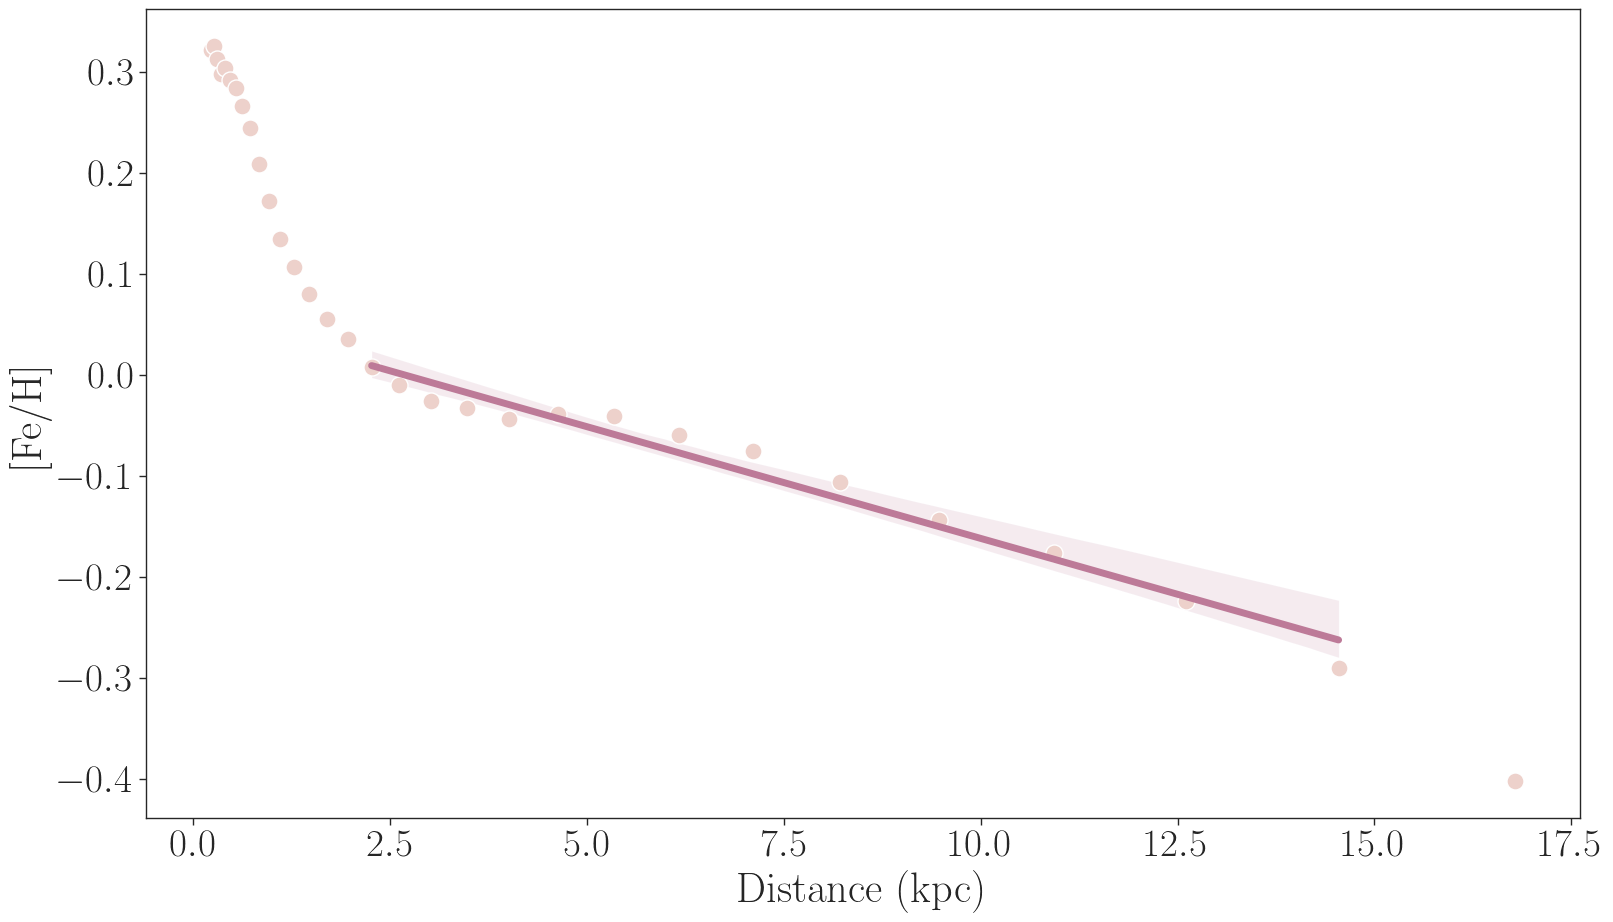

In [11]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    sns.regplot(
        data[data["Distance (kpc)"].between(*fit_range)],
        x="Distance (kpc)",
        y="[Fe/H]",
        color=get_palette()[2],
        scatter=False,
        line_kws={"linewidth": 5},
        ax=ax,
    )
    sns.scatterplot(
        data[data["Distance (kpc)"].between(0.2, 18)],
        x="Distance (kpc)",
        y="[Fe/H]",
        color=get_palette()[0],
        s=150,
        ax=ax,
    )